<a id="introduction"></a>
## Introduction to Supervised Learning
#### By Paul Hendricks
-------

In this notebook, we will show to do GPU accelerated Supervised Learning in RAPIDS.  We will not cover SGD Regression at this time.

**Table of Contents**

* [Introduction to Supervised Learning](#introduction)
* [Linear Regression](#linear)
* [Ridge Regression](#ridge)
* [K Nearest Neighbors](#knn)
* [Setup](#setup)
* [Conclusion](#conclusion)

Before going any further, let's make sure we have access to `matplotlib`, a popular Python library for visualizing data.

In [1]:
import os
import cupy as cp
import subprocess

try:
    import matplotlib
except ModuleNotFoundError:
    os.system('conda install -y matplotlib')
    import matplotlib


<a id="setup"></a>
## Setup

This notebook was tested using the `rapidsai/rapidsai-core-dev-nightly:22.04-cuda11.5-devel-ubuntu20.04-py3.9` container from [DockerHub](https://hub.docker.com/r/rapidsai/rapidsai-core-dev-nightly) and run on the NVIDIA GV100 GPU. Please be aware that your system may be different and you may need to modify the code or install packages to run the below examples. 

If you think you have found a bug or an error, please file an issue here:  https://github.com/rapidsai-community/notebooks-contrib/issues

Before we begin, let's check out our hardware setup by running the `nvidia-smi` command.

In [2]:
!nvidia-smi

Tue Apr  5 02:25:07 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 495.44       CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:06:00.0 Off |                    0 |
| N/A   33C    P0    55W / 300W |   6556MiB / 32510MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  On   | 00000000:07:00.0 Off |                    0 |
| N/A   

Next, let's see what CUDA version we have:

In [3]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Thu_Nov_18_09:45:30_PST_2021
Cuda compilation tools, release 11.5, V11.5.119
Build cuda_11.5.r11.5/compiler.30672275_0


Next, let's load some helper functions from `matplotlib` and configure the Jupyter Notebook for visualization.

In [4]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt


%matplotlib inline

<a id="linear"></a>
## Linear Regression

After our data has been preprocessed, we often want to build a model so as to understand the relationships between different variables in our data. Scikit-Learn is an incredibly powerful toolkit that allows data scientists to quickly build models from their data. Below we show a simple example of how to create a Linear Regression model.

In [5]:
import numpy as np; print('NumPy Version:', np.__version__)


# create the relationship: y = 2.0 * x + 1.0

n_rows = 4600
w = 2.0
x = np.random.normal(loc=0, scale=1, size=(n_rows,))
b = 1.0
y = w * x + b

# add a bit of noise
noise = np.random.normal(loc=0, scale=2, size=(n_rows,))
y_noisy = y + noise

NumPy Version: 1.21.5


We can now visualize our data using the `matplotlib` library.

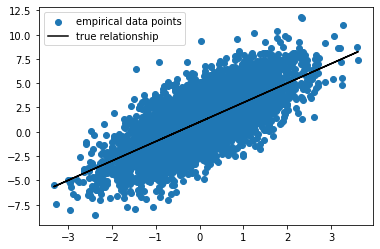

In [6]:
plt.scatter(x, y_noisy, label='empirical data points')
plt.plot(x, y, color='black', label='true relationship')
plt.legend()

We'll use the `LinearRegression` class from Scikit-Learn to instantiate a model and fit it to our data.

In [7]:
import sklearn; print('Scikit-Learn Version:', sklearn.__version__)
from sklearn.linear_model import LinearRegression


# instantiate and fit model
linear_regression = LinearRegression()

Scikit-Learn Version: 0.24.2


In [8]:
%%time

linear_regression.fit(np.expand_dims(x, 1), y)

CPU times: user 0 ns, sys: 2.54 ms, total: 2.54 ms
Wall time: 1.67 ms


LinearRegression()

In [9]:
# create new data and perform inference
inputs = np.linspace(start=-5, stop=5, num=1000)
outputs = linear_regression.predict(np.expand_dims(inputs, 1))

Let's now visualize our empirical data points, the true relationship of the data, and the relationship estimated by the model. Looks pretty close!

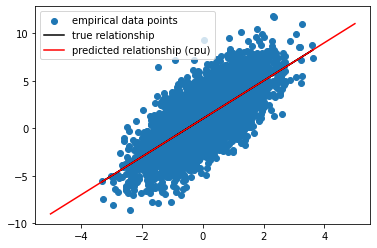

In [10]:
plt.scatter(x, y_noisy, label='empirical data points')
plt.plot(x, y, color='black', label='true relationship')
plt.plot(inputs, outputs, color='red', label='predicted relationship (cpu)')
plt.legend()

The mathematical operations underlying many machine learning algorithms are often matrix multiplications. These types of operations are highly parallelizable and can be greatly accelerated using a GPU. cuML makes it easy to build machine learning models in an accelerated fashion while still using an interface nearly identical to Scikit-Learn. The below shows how to accomplish the same Linear Regression model but on a GPU.

First, let's convert our data from a NumPy representation to a cuDF representation.

In [11]:
import cudf; print('cuDF Version:', cudf.__version__)


# create a cuDF DataFrame
df = cudf.DataFrame({'x': x, 'y': y_noisy})
print(df.head())

cuDF Version: 22.04.00a0+g2c81bed
          x         y
0  0.185811  2.380854
1  0.089171 -0.565413
2 -1.032118 -0.730538
3 -0.666890  0.610796
4  0.599718  1.322041


Next, we'll load the GPU accelerated `LinearRegression` class from cuML, instantiate it, and fit it to our data.

In [12]:
import cuml; print('cuML Version:', cuml.__version__)
from cuml.linear_model import LinearRegression as LinearRegression_GPU


# instantiate and fit model
linear_regression_gpu = LinearRegression_GPU()

cuML Version: 22.04.00a0+gc07e162


In [13]:
%%time

linear_regression_gpu.fit(df['x'], df['y'])

/opt/conda/envs/rapids/lib/python3.9/site-packages/cuml/internals/api_decorators.py:409: UserWarning: Changing solver from 'eig' to 'svd' as eig solver does not support training data with 1 column currently.
  return func(*args, **kwargs)


CPU times: user 511 ms, sys: 174 ms, total: 685 ms
Wall time: 684 ms


LinearRegression()

We can use this model to predict values for new data points, a step often called "inference" or "scoring". All model fitting and predicting steps are GPU accelerated.

In [14]:
# create new data and perform inference
new_data_df = cudf.DataFrame({'inputs': inputs})
outputs_gpu = linear_regression_gpu.predict(new_data_df[['inputs']])

Lastly, we can overlay our predicted relationship using our GPU accelerated Linear Regression model (green line) over our empirical data points (light blue circles), the true relationship (blue line), and the predicted relationship from a model built on the CPU (red line). We see that our GPU accelerated model's estimate of the true relationship (green line) is identical to the CPU based model's estimate of the true relationship (red line)!

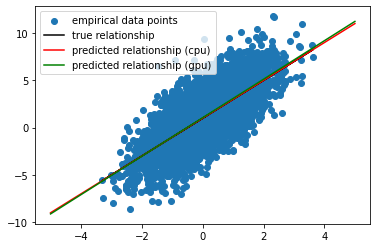

In [15]:
plt.scatter(x, y_noisy, label='empirical data points')
plt.plot(x, y, color='black', label='true relationship')
plt.plot(inputs, outputs, color='red', label='predicted relationship (cpu)')
plt.plot(inputs, outputs_gpu.to_numpy(), color='green', label='predicted relationship (gpu)')
plt.legend()

<a id="ridge"></a>
## Ridge Regression

Ridge extends LinearRegression by providing L2 regularization on the coefficients when predicting response y with a linear combination of the predictors in X. It can reduce the variance of the predictors, and improves the conditioning of the problem.

Below, we instantiate and fit a Ridge Regression model to our data.

In [16]:
from cuml.linear_model import Ridge as Ridge_GPU


# instantiate and fit model
ridge_regression_gpu = Ridge_GPU()

In [17]:
%%time

ridge_regression_gpu.fit(df[['x']], df['y'])

CPU times: user 2.32 ms, sys: 3.57 ms, total: 5.89 ms
Wall time: 5.13 ms


/opt/conda/envs/rapids/lib/python3.9/site-packages/cuml/internals/api_decorators.py:409: UserWarning: Changing solver to 'svd' as 'eig' or 'cd' solvers do not support training data with 1 column currently.
  return func(*args, **kwargs)


Ridge()

Similar to the `LinearRegression` model we fitted early, we can use the `predict` method to generate predictions for new data.

In [18]:
outputs_gpu = ridge_regression_gpu.predict(new_data_df[['inputs']])

Lastly, we can visualize our `Ridge` model's estimated relationship and overlay it our the empirical data points.

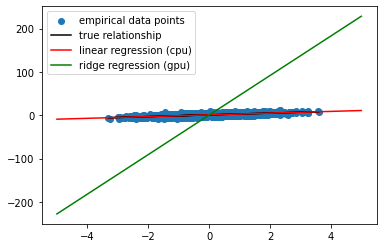

In [19]:
plt.scatter(x, y_noisy, label='empirical data points')
plt.plot(x, y, color='black', label='true relationship')
plt.plot(inputs, outputs, color='red', label='linear regression (cpu)')
plt.plot(inputs, outputs_gpu.to_numpy(), color='green', label='ridge regression (gpu)')
plt.legend()

<a id="knn"></a>
## K Nearest Neighbors

NearestNeighbors is a unsupervised algorithm where if one wants to find the “closest” datapoint(s) to new unseen data, one can calculate a suitable “distance” between each and every point, and return the top K datapoints which have the smallest distance to it.

We'll generate some fake data using the `make_moons` function from the `sklearn.datasets` module. This function generates data points from two equations, each describing a half circle with a unique center. Since each data point is generated by one of these two equations, the cluster each data point belongs to is clear. The ideal classification algorithm will identify two clusters and associate each data point with the equation that generated it. 

These data points are generated using a non-linear relationship - so using a linear regression approach won't adequately solve problem. Instead, we can use a distance-based algorithm K Nearest Neighbors to classify each data point.

First, let's generate out data.

In [20]:
from sklearn.datasets import make_moons


X, y = make_moons(n_samples=int(1e3), noise=0.05, random_state=0)
print(X.shape)

(1000, 2)


Let's visualize our data:

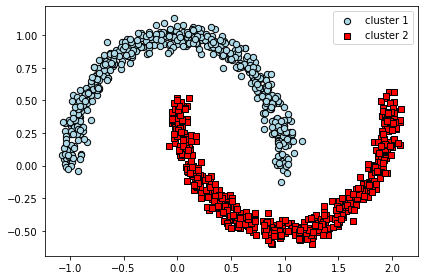

In [21]:
figure = plt.figure()
axis = figure.add_subplot(111)
axis.scatter(X[y == 0, 0], X[y == 0, 1], 
             edgecolor='black',
             c='lightblue', marker='o', s=40, label='cluster 1')

axis.scatter(X[y == 1, 0], X[y == 1, 1], 
             edgecolor='black',
             c='red', marker='s', s=40, label='cluster 2')
plt.legend()
plt.tight_layout()
plt.show()

Before we build a KNN classification model, we first have to convert our data to a cuDF representation.

In [22]:
X_df = cudf.DataFrame()
for column in range(X.shape[1]):
    X_df['feature_' + str(column)] = np.ascontiguousarray(X[:, column])

y_df = cudf.Series(y)

Next, we'll instantiate and fit a nearest neighbors model using the `NearestNeighbors` class from cuML.

In [23]:
from cuml.neighbors import NearestNeighbors


knn = NearestNeighbors()

In [24]:
knn.fit(X_df)

NearestNeighbors()

Once our model has been built and fitted to the data, we can query the model for the `k` nearest neighbors to each data point. The query returns a matrix representating the distances of each data point to its nearest `k` neighbors as well as the indices of those neighbors.

In [25]:
k = 3

distances, indices = knn.kneighbors(X_df, n_neighbors=k)

We can iterate through each of our data points and do a majority vote to determine which class it belongs to.

In [26]:
predictions = []
#cp_y = cp.asarray(y_df)
cp_y = y_df.astype(cp.int_)
for i in range(indices.shape[0]):
    row = indices.iloc[i, :].values
    vote = sum(cp_y[j] for j in row) / k
    predictions.append(1.0 * (vote > 0.5))

predictions = np.asarray(predictions).astype(np.float32)

Lastly, we can visualize the predictions from our K Nearest Neighbors classifier - we see that despite the non-linearity of the data, the algorithm does an excellent job of classifying the data.

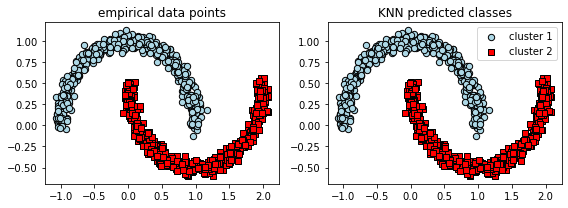

In [27]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))


ax1.scatter(X[y == 0, 0], X[y == 0, 1],
            edgecolor='black',
            c='lightblue', marker='o', s=40, label='cluster 1')
ax1.scatter(X[y == 1, 0], X[y == 1, 1],
            edgecolor='black',
            c='red', marker='s', s=40, label='cluster 2')
ax1.set_title('empirical data points')


ax2.scatter(X[predictions == 0, 0], X[predictions == 0, 1], c='lightblue',
            edgecolor='black',
            marker='o', s=40, label='cluster 1')
ax2.scatter(X[predictions == 1, 0], X[predictions == 1, 1], c='red',
            edgecolor='black',
            marker='s', s=40, label='cluster 2')
ax2.set_title('KNN predicted classes')

plt.legend()
plt.tight_layout()
plt.show()

<a id="conclusion"></a>
## Conclusion

In this notebook, we showed to do GPU accelerated Supervised Learning in RAPIDS. 

To learn more about RAPIDS, be sure to check out: 

* [Open Source Website](http://rapids.ai)
* [GitHub](https://github.com/rapidsai/)
* [Press Release](https://nvidianews.nvidia.com/news/nvidia-introduces-rapids-open-source-gpu-acceleration-platform-for-large-scale-data-analytics-and-machine-learning)
* [NVIDIA Blog](https://blogs.nvidia.com/blog/2018/10/10/rapids-data-science-open-source-community/)
* [Developer Blog](https://devblogs.nvidia.com/gpu-accelerated-analytics-rapids/)
* [NVIDIA Data Science Webpage](https://www.nvidia.com/en-us/deep-learning-ai/solutions/data-science/)
